# Predicting Rental Prices in Brazil

## ABSTRACT

What follows is a python 3 workbook containing an exploratory analysis of the data scraped from a Brazillian real-estate website by kaggle user Rubens Junior (https://www.kaggle.com/rubenssjr/brasilian-houses-to-rent), as well as an attempt at fitting a regression model to the data in order to allow the prediction rental property prices.

After visualising the data and trimming off the outliers, a multiple Log regression was performed, which could very accurately predict the rental prices of lower-cost properties, but failed to model the rental prices of more expensive properties (~25-30% error @ 50% percentile). I decided to try to split the data into clusters using KMeans clustering in order to create three separate models, hoping maybe to more accurately model the behaviour of more expensive apartments, but this returned worse results than the original model.

This suggests that while total floor space, the number of rooms, etc are good predictors for cheap apartments, there are some other major factors effecting the price of more expensive properties, perhaps the neighbourhood, type of apartment building, or accessibility of utilities and public transport.


## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
sns.set()

## Load in the data


In [2]:
raw_data = pd.read_csv('houses_to_rent.csv')
raw_data.describe(include = 'all')

,Unnamed: 0,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa,rent amount,property tax,fire insurance,total
count,6080.00000,6080.000000,6080.000000,6080.000000,6080.000000,6080.000000,6080,6080,6080,6080,6080,6080,6080,6080
unique,NaN,NaN,NaN,NaN,NaN,NaN,37,2,2,1292,1032,1036,190,4069
top,NaN,NaN,NaN,NaN,NaN,NaN,-,acept,not furnished,R$0,"R$15,000",R$0,R$23,"R$2,555"
freq,NaN,NaN,NaN,NaN,NaN,NaN,1555,4666,4498,1291,155,1053,163,35
mean,3039.50000,0.863322,151.143914,2.492599,2.341612,1.756250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,1755.28915,0.343535,375.559485,1.129665,1.438860,1.611909,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.00000,0.000000,10.000000,1.000000,1.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,1519.75000,1.000000,58.000000,2.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,3039.50000,1.000000,100.000000,3.000000,2.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,4559.25000,1.000000,200.000000,3.000000,3.000000,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Data Preprocessing

In [3]:
#can drop unnamed column, it's just an index. Will have to remove R$ sign 
#hoa (homeowners association tax) & Property tax columns have two extra values, Sem Info and Incluso which will be turned to 0


#Note! City already turned into dummy variable by Kaggle User Rubens Junior


data = raw_data.drop(['Unnamed: 0'],axis =1)
data['hoa'] = data['hoa'].replace('Sem info','0')
data['hoa'] = data['hoa'].replace('Incluso','0')

data['property tax'] = data['property tax'].replace('Sem info','0')
data['property tax'] = data['property tax'].replace('Incluso','0')




data.head()


,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa,rent amount,property tax,fire insurance,total
0,1,240,3,3,4,-,acept,furnished,R$0,"R$8,000","R$1,000",R$121,"R$9,121"
1,0,64,2,1,1,10,acept,not furnished,R$540,R$820,R$122,R$11,"R$1,493"
2,1,443,5,5,4,3,acept,furnished,"R$4,172","R$7,000","R$1,417",R$89,"R$12,680"
3,1,73,2,2,1,12,acept,not furnished,R$700,"R$1,250",R$150,R$16,"R$2,116"
4,1,19,1,1,0,-,not acept,not furnished,R$0,"R$1,200",R$41,R$16,"R$1,257"


In [4]:
#Multiple options for how to deal with the missing values in the data detailing which floor the property is on

#option 1
#filling the NaN values with the median value of the column

data['floor']=data['floor'].replace('-',np.nan)
data['floor']=data['floor'].fillna(data['floor'].median()).astype('int')

#Option 2, assume on the ground floor

#data['floor']=data['floor'].replace('-',0).astype('int')

#Option 3, simply remove ~1500 data entries from a set of ~6100
#Didn't really want to do this as the data set is already pretty small.


#data['floor'] = data['floor'].replace('-', np.nan)
#data.dropna(axis=0,inplace = True)
#data['floor']= data['floor'].astype('int')

#### Note on dealing with empty values in the floor data

I explored each of these options, comparing the effects that they ultimately had on the final regression model. The three different models performed essentially the same, differing by less than 0.01% in their predictions. 

This also supported my theory that the inaccuracy of the regression model is largely due to other factors having an effect on rental prices, which were not captured by the data provided on the website.

### Build function to clean off R$ sign and commas

In [5]:
def extract_value_from(Value):
    out = Value.replace('R$','')
    out_ = out.replace(',','')
    out_ = float(out_)
    return out_
    

In [6]:
data['hoa'] = data['hoa'].apply(lambda x: extract_value_from(x))
data['property tax'] = data['property tax'].apply(lambda x: extract_value_from(x))
data['rent amount'] = data['rent amount'].apply(lambda x: extract_value_from(x))
data['fire insurance'] = data['fire insurance'].apply(lambda x: extract_value_from(x))
data['total'] = data['total'].apply(lambda x: extract_value_from(x))

data_no_R = data
data_no_R.describe(include = 'all')

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa,rent amount,property tax,fire insurance,total
count,6080.000000,6080.000000,6080.000000,6080.000000,6080.000000,6080.000000,6080,6080,6080.000000,6080.000000,6080.000000,6080.000000,6080.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,2,2,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,acept,not furnished,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,4666,4498,NaN,NaN,NaN,NaN,NaN
mean,0.863322,151.143914,2.492599,2.341612,1.756250,7.206743,NaN,NaN,1088.426480,4395.844408,490.333388,58.204276,6033.194572
std,0.343535,375.559485,1.129665,1.438860,1.611909,5.243834,NaN,NaN,3981.357627,3576.668946,6212.564538,49.313441,8751.347700
min,0.000000,10.000000,1.000000,1.000000,0.000000,1.000000,NaN,NaN,0.000000,420.000000,0.000000,3.000000,660.000000
25%,1.000000,58.000000,2.000000,1.000000,1.000000,4.000000,NaN,NaN,24.500000,1800.000000,33.000000,23.000000,2451.500000
50%,1.000000,100.000000,3.000000,2.000000,1.000000,6.000000,NaN,NaN,650.000000,3111.000000,145.000000,41.000000,4128.500000
75%,1.000000,200.000000,3.000000,3.000000,2.000000,9.000000,NaN,NaN,1436.000000,5952.500000,458.000000,77.000000,8074.000000


## Preliminary Visualisation

Text(0.5, 1.0, 'City and Total Price')

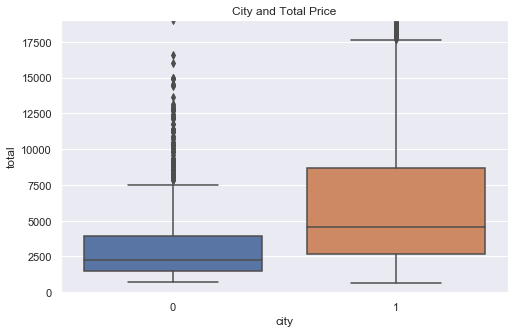

In [7]:
plt.figure(figsize=(8,5))
sns.boxplot(x=data_no_R['city'],y=data_no_R['total'])
plt.ylim(0,19000) 
#Heaps of very high-rent outliers so limited y-axis to make the graphs useful.
#Will use quantiles to trim off outliers in the next step
plt.title('City and Total Price')

Text(0.5, 1.0, 'Room and Total Price')

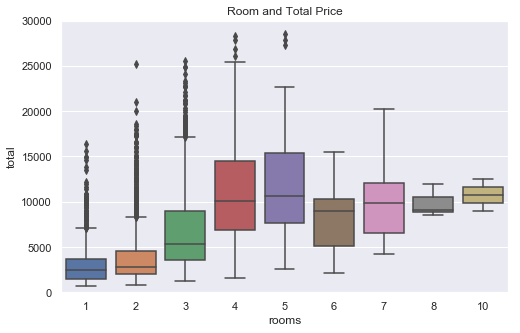

In [8]:
plt.figure(figsize=(8,5))
sns.boxplot(x=data_no_R['rooms'],y=data_no_R['total'])
plt.ylim(0,30000)
plt.title('Room and Total Price')

Text(0.5, 1.0, 'Bathroom and Total Price')

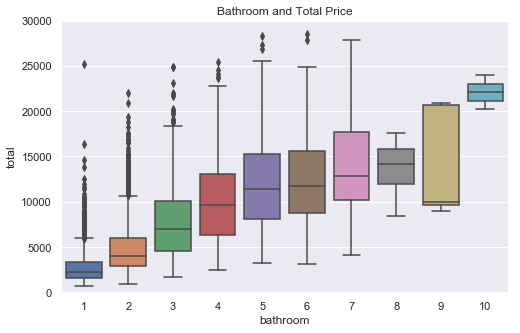

In [9]:
plt.figure(figsize=(8,5))
sns.boxplot(x=data_no_R['bathroom'],y=data_no_R['total'])
plt.ylim(0,30000)
plt.title('Bathroom and Total Price')

Text(0.5, 1.0, 'Parking Spaces and Total Price')

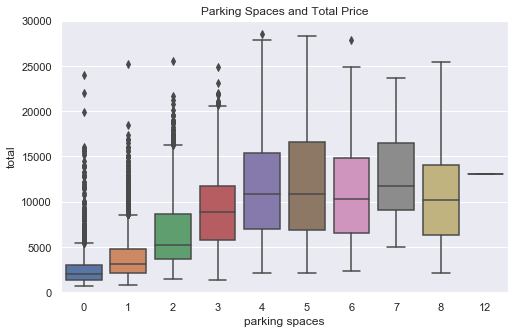

In [10]:
plt.figure(figsize=(8,5))
sns.boxplot(x=data_no_R['parking spaces'],y=data_no_R['total'])
plt.ylim(0,30000)
plt.title('Parking Spaces and Total Price')


Text(0.5, 1.0, 'Floor and Total Price')

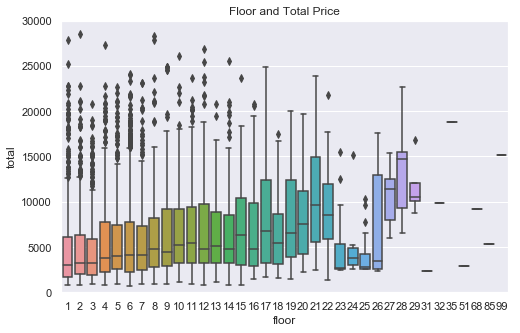

In [11]:
#Note: here we can see the trends in building heights in these Brazillian cities. 
#Rental costs increase with height but show regular 'dips,' possibly representing the intersection of the
# "penthouses" of smaller buildings with the middle floors of taller buildings

plt.figure(figsize=(8,5))
sns.boxplot(x=data_no_R['floor'],y=data_no_R['total'])
plt.ylim(0,30000)
plt.title('Floor and Total Price')

Text(0.5, 1.0, 'Animals Allowed and Total Price')

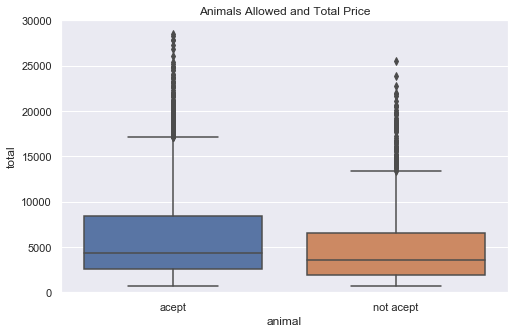

In [12]:
plt.figure(figsize=(8,5))
sns.boxplot(x=data_no_R['animal'],y=data_no_R['total'])
plt.ylim(0,30000)
plt.title('Animals Allowed and Total Price')

Text(0.5, 1.0, 'Bathrooms per Number of Rooms')

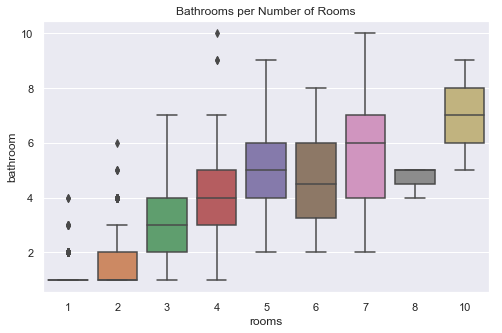

In [13]:
plt.figure(figsize=(8,5))
sns.boxplot(x=data_no_R['rooms'],y=data_no_R['bathroom'])
plt.title('Bathrooms per Number of Rooms')

# Preparing and Building Regression Model

## Check for Multicollinearity

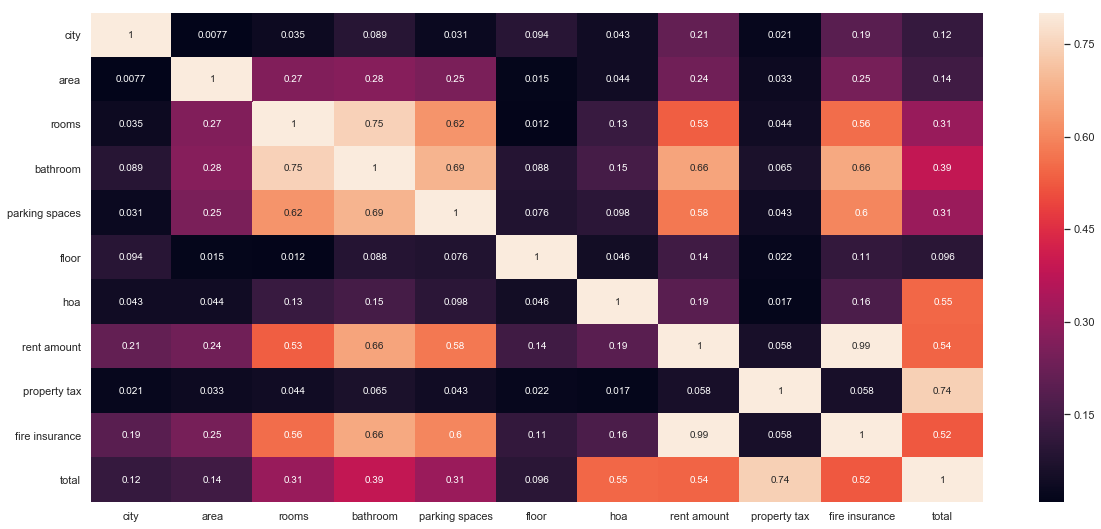

In [14]:
corrmat = data_no_R.corr()
f,ax=plt.subplots(figsize=(20,9))
sns.heatmap(corrmat,vmax=0.8,annot=True)

In [15]:
#High degree of multicollinearity between fire insurance and rent amount, so drop fire insurance
#Dropping total because it's simply the sum of all the costs (rent, insurances, hoa & property tax)


from statsmodels.stats.outliers_influence import variance_inflation_factor
variables = data_no_R[['rent amount','hoa','property tax','fire insurance']]
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(variables.values,i) for i in range(variables.shape[1])]
vif['features'] = variables.columns
vif

,VIF,features
0,87.495150,rent amount
1,1.143901,hoa
2,1.009709,property tax
3,86.399463,fire insurance


In [16]:
# High multicollinearity between number of bathrooms and number of rooms also to be expected but bathrooms will need to be dropped too

variables = data_no_R[['rooms','bathroom','parking spaces','rent amount']]
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(variables.values,i) for i in range(variables.shape[1])]
vif['features'] = variables.columns
vif

,VIF,features
0,8.592233,rooms
1,11.504419,bathroom
2,4.448413,parking spaces
3,4.631909,rent amount


In [17]:
data_no_R = data_no_R.drop(['fire insurance'],axis=1)
data_no_R = data_no_R.drop(['total'],axis=1)
data_no_R = data_no_R.drop(['bathroom'],axis=1)

## Explore Probability Distribution Functions

C:\Users\josep\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


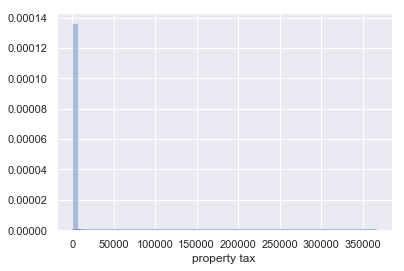

In [18]:
sns.distplot(data_no_R['property tax'])

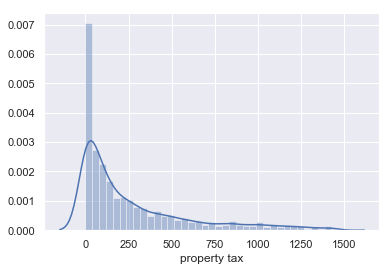

In [19]:
# seeing some very expensive properties skewing the data here, as evidenced by the quartile-breakdown shown by describe function above.
# Cut some of the outliers out

q = data_no_R['property tax'].quantile(0.95)
data_1 = data_no_R[data_no_R['property tax']<q]
sns.distplot(data_1['property tax'])

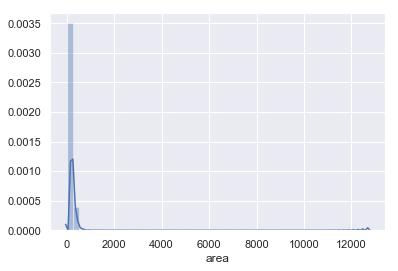

In [20]:
sns.distplot(data_1['area'])

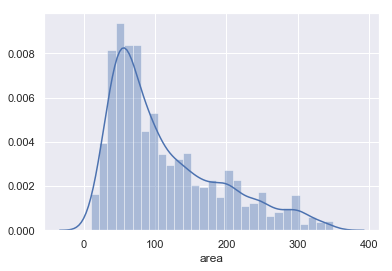

In [21]:
q = data_1['area'].quantile(0.95)
data_2 = data_1[data_1['area']<q]
sns.distplot(data_2['area'])

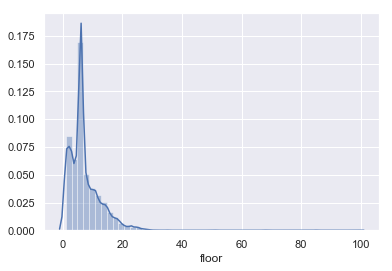

In [22]:
sns.distplot(data_2['floor'])

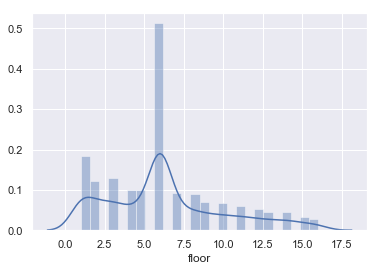

In [23]:
q = data_2['floor'].quantile(0.95)
data_3 = data_2[data_2['floor']<q]
sns.distplot(data_3['floor'])

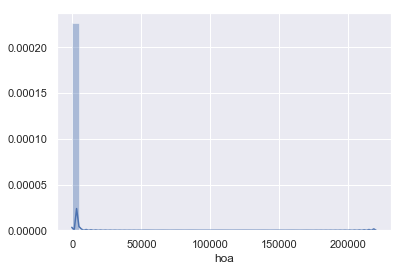

In [24]:
sns.distplot(data_3['hoa'])

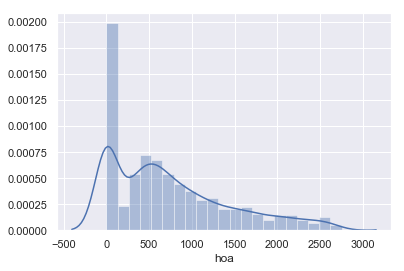

In [25]:
q = data_3['hoa'].quantile(0.95)
data_4 = data_3[data_3['hoa']<q]
sns.distplot(data_4['hoa'])

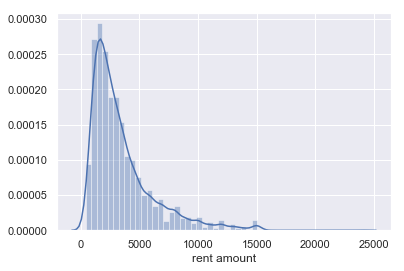

In [26]:
sns.distplot(data_4['rent amount'])

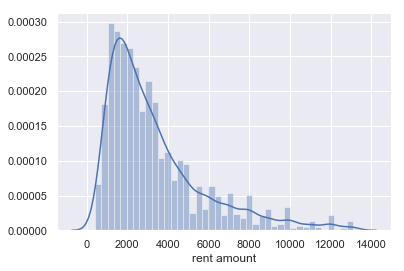

In [27]:
q = data_4['rent amount'].quantile(0.99)
data_5 = data_4[data_4['rent amount']<q]
sns.distplot(data_5['rent amount'])

#not normally distributed. Try Log transformation

In [28]:
data_cleaned = data_5.reset_index(drop=True)
data_cleaned.describe(include='all')

,city,area,rooms,parking spaces,floor,animal,furniture,hoa,rent amount,property tax
count,4825.000000,4825.000000,4825.000000,4825.000000,4825.000000,4825,4825,4825.000000,4825.000000,4825.000000
unique,NaN,NaN,NaN,NaN,NaN,2,2,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,acept,not furnished,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,3645,3639,NaN,NaN,NaN
mean,0.844145,106.332228,2.270052,1.390466,6.277720,NaN,NaN,737.311710,3362.107772,201.260518
std,0.362755,70.954991,1.001359,1.295192,3.702277,NaN,NaN,690.663849,2423.842136,252.018210
min,0.000000,10.000000,1.000000,0.000000,1.000000,NaN,NaN,0.000000,420.000000,0.000000
25%,1.000000,53.000000,1.000000,1.000000,4.000000,NaN,NaN,26.000000,1650.000000,20.000000
50%,1.000000,83.000000,2.000000,1.000000,6.000000,NaN,NaN,592.000000,2600.000000,105.000000
75%,1.000000,140.000000,3.000000,2.000000,8.000000,NaN,NaN,1100.000000,4300.000000,286.000000


In [29]:
#Rental Prices may not be normal enough for linear regression, so a logistic regression will be conducted instead

log_rent = np.log(data_cleaned['rent amount'])
data_cleaned['log_rent'] = log_rent
data_cleaned = data_cleaned.drop(['rent amount'],axis=1)

## Create Dummy Variables and Train and Test Sets 

In [30]:
data_with_dummies = pd.get_dummies(data_cleaned, drop_first=True)
data_with_dummies.head()

,city,area,rooms,parking spaces,floor,hoa,property tax,log_rent,animal_not acept,furniture_not furnished
0,1,240,3,4,6,0.0,1000.0,8.987197,0,0
1,0,64,2,1,10,540.0,122.0,6.709304,0,1
2,1,73,2,1,12,700.0,150.0,7.130899,0,1
3,1,19,1,0,6,0.0,41.0,7.090077,1,1
4,1,13,1,0,2,0.0,42.0,7.696213,0,1


## Create Test and Train sets

In [31]:
#rearrange columns manually
data_with_dummies.columns.values

array(['city', 'area', 'rooms', 'parking spaces', 'floor', 'hoa',
       'property tax', 'log_rent', 'animal_not acept',
       'furniture_not furnished'], dtype=object)

In [32]:
cols = ['log_rent','city', 'area', 'rooms',  'parking spaces', 'floor',
       'hoa', 'property tax', 
       'animal_not acept', 'furniture_not furnished']

In [33]:
data_preprocessed = data_with_dummies[cols]
data_preprocessed.head()

,log_rent,city,area,rooms,parking spaces,floor,hoa,property tax,animal_not acept,furniture_not furnished
0,8.987197,1,240,3,4,6,0.0,1000.0,0,0
1,6.709304,0,64,2,1,10,540.0,122.0,0,1
2,7.130899,1,73,2,1,12,700.0,150.0,0,1
3,7.090077,1,19,1,0,6,0.0,41.0,1,1
4,7.696213,1,13,1,0,2,0.0,42.0,0,1


### Do the Regression

In [34]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#Declare inputs and targets
targets = data_preprocessed['log_rent']
inputs = data_preprocessed.drop(['log_rent'],axis = 1)

#to standardise the inputs
scaler = StandardScaler()
scaler.fit(inputs)
inputs_scaled = scaler.transform(inputs)

#Split the data into train and test groups
x_train,x_test,y_train,y_test = train_test_split(inputs_scaled, targets,test_size=0.2,random_state = 365)

#do the regression
reg = LinearRegression()
reg.fit(x_train,y_train)

y_hat = reg.predict(x_train) #predicted results

C:\Users\josep\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\josep\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  # This is added back by InteractiveShellApp.init_path()


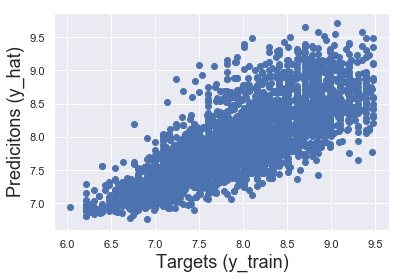

In [35]:
plt.scatter(y_train,y_hat)
plt.xlabel('Targets (y_train)',size=18)
plt.ylabel('Predicitons (y_hat)',size = 18)
plt.show()

#good fit for low-rent properties

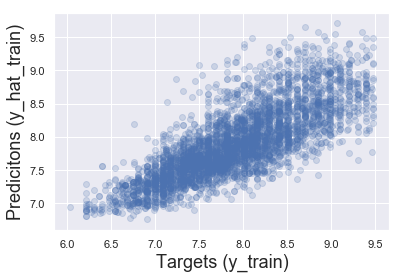

In [36]:
plt.scatter(y_train,y_hat,alpha = 0.2)
plt.xlabel('Targets (y_train)',size=18)
plt.ylabel('Predicitons (y_hat_train)',size = 18)

plt.show()

C:\Users\josep\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Residuals PDF')

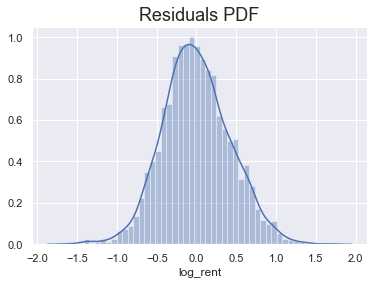

In [37]:
sns.distplot(y_train - y_hat)
plt.title('Residuals PDF',fontsize=18)

#lack of significant tails on either size suggests that the model doesn't typically over- or underestimate the rental prices

In [38]:
reg.score(x_train,y_train)

0.6092131706921949

In [39]:
reg.intercept_

7.895036762368424

In [40]:
reg_summary = pd.DataFrame(inputs.columns.values,columns=['Features'])
reg_summary['Weights'] = reg.coef_
reg_summary

#continuous variables:
#positive weight shows as rental price increases, so does the variable
#negative weight shows as the feature increases, rental price decreases


#dummy variables:
#a positive weight shows the respective alternative is more expensive
#than the benchmark(furnished/pets allowed)
#a negative weight shows the alternative costs less to rent than the benchmark


#the bigger the weight, the bigger the impact.


#Most of the factors captured by the data seemed to have a similar effect on the price of the houses

,Features,Weights
0,city,0.172327
1,area,0.243606
2,rooms,0.052405
3,parking spaces,0.091612
4,floor,0.055266
5,hoa,0.123891
6,property tax,0.059789
7,animal_not acept,-0.017302
8,furniture_not furnished,-0.142483


## Testing the model

In [41]:
y_hat_test = reg.predict(x_test)

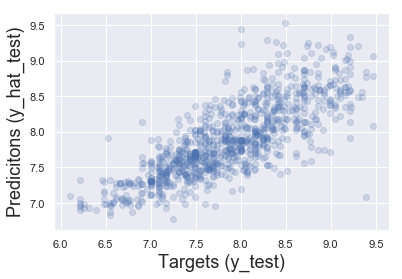

In [42]:
plt.scatter(y_test,y_hat_test,alpha = 0.2)
plt.xlabel('Targets (y_test)',size=18)
plt.ylabel('Predicitons (y_hat_test)',size = 18)

plt.show()

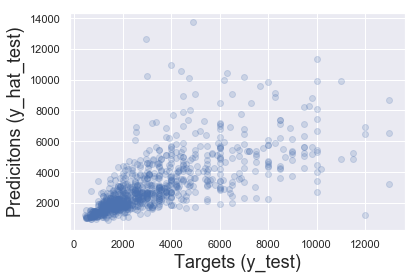

In [43]:

plt.scatter(np.exp(y_test),np.exp(y_hat_test),alpha = 0.2)
plt.xlabel('Targets (y_test)',size=18)
plt.ylabel('Predicitons (y_hat_test)',size = 18)

plt.show()

## Final summaries of the Model

In [44]:
df_pf = pd.DataFrame(np.exp(y_hat_test), columns=['Prediction'])
y_test = y_test.reset_index(drop = True)
df_pf['Target'] = np.exp(y_test)
df_pf['Residual'] = df_pf['Target'] - df_pf['Prediction']
df_pf['Difference%'] = np.absolute(df_pf['Residual']/df_pf['Target'] *100)
df_pf.describe()

,Prediction,Target,Residual,Difference%
count,965.000000,965.000000,965.000000,965.000000
mean,3066.147677,3268.726425,202.578747,35.126182
std,1835.719142,2320.484359,1708.803327,32.303125
min,872.298968,450.000000,-9672.502660,0.108442
25%,1809.953308,1623.000000,-560.450257,14.252066
50%,2517.720551,2600.000000,-107.620189,27.250207
75%,3793.066022,4100.000000,733.974615,46.033037
max,13709.117966,13000.000000,10812.602878,325.126140


In [45]:
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error


y_pred = reg.predict(x_test)
print("regressor score is", reg.score(x_train , y_train))
rscore = r2_score(y_test,y_pred)
print("r2score is", rscore)
mae = mean_absolute_error(y_test,y_pred)
print("mean absolute error is",mae)
mse = mean_squared_error(y_test,y_pred)
print("mean squared error is",np.sqrt(mse))

regressor score is 0.6092131706921949
r2score is 0.6161789192796319
mean absolute error is 0.33159169015051726
mean squared error is 0.4169920320549234


### KMeans Clustering and rebuilding the model

In [46]:
data_KMeans = data_preprocessed.copy()
exp_rent = np.exp(data_KMeans['log_rent'])
data_KMeans['rent amount'] = exp_rent
data_KMeans=data_KMeans.drop(['log_rent'],axis=1)

data_KMeans_nodummies=data_KMeans.drop(['animal_not acept'],axis=1)
data_KMeans_nodummies=data_KMeans_nodummies.drop(['furniture_not furnished'],axis=1)
data_KMeans_nodummies.head()

,city,area,rooms,parking spaces,floor,hoa,property tax,rent amount
0,1,240,3,4,6,0.0,1000.0,8000.0
1,0,64,2,1,10,540.0,122.0,820.0
2,1,73,2,1,12,700.0,150.0,1250.0
3,1,19,1,0,6,0.0,41.0,1200.0
4,1,13,1,0,2,0.0,42.0,2200.0


### Rescaling the attributes

Need to rescale the variables using Standardisation Scaling to make them comparable.

In [47]:
# Instantiate
scaler = StandardScaler()

# fit_transform
scaler.fit(data_KMeans_nodummies)
data_KMeans_scaled = scaler.transform(data_KMeans_nodummies)
data_KMeans_scaled.shape

C:\Users\josep\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\josep\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  


(4825, 8)

In [48]:
data_KMeans_scaled = pd.DataFrame(data_KMeans_scaled)

#data_KMeans_scaled.columns = ['city','area','rooms','parking spaces','floor','hoa','property tax','animal_not acept','furniture_not furnished','rent amount']
data_KMeans_scaled.columns = ['city','area','rooms','parking spaces','floor','hoa','property tax','rent amount']
data_KMeans_scaled.head()

,city,area,rooms,parking spaces,floor,hoa,property tax,rent amount
0,0.429687,1.884034,0.729033,2.014995,-0.075021,-1.067651,3.169701,1.913645
1,-2.327278,-0.596669,-0.269713,-0.301505,1.005507,-0.285714,-0.314536,-1.048901
2,0.429687,-0.469814,-0.269713,-0.301505,1.545771,-0.054029,-0.203421,-0.871479
3,0.429687,-1.230939,-1.268459,-1.073672,-0.075021,-1.067651,-0.635974,-0.892109
4,0.429687,-1.315509,-1.268459,-1.073672,-1.155549,-1.067651,-0.632006,-0.479498


### Starting KMeans clustering

In [49]:
from sklearn.cluster import KMeans
#Initialise with arbitrary k

kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(data_KMeans_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
    n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [50]:
kmeans.labels_

array([0, 3, 1, ..., 3, 0, 1])

#### Use Elbow Curve Method to get the appropriate amount of clusters

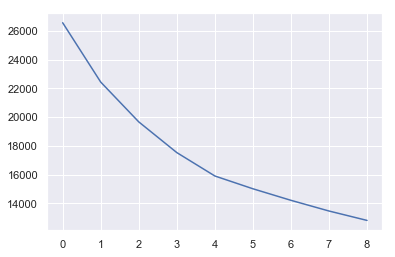

In [51]:
# Elbow-curve/SSD

ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=75)
    kmeans.fit(data_KMeans_scaled)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
plt.plot(ssd)

In [52]:
# Silhouette analysis

from sklearn.metrics import silhouette_score


for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(data_KMeans_scaled)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(data_KMeans_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.3282884292673842
For n_clusters=3, the silhouette score is 0.30182907838006395
For n_clusters=4, the silhouette score is 0.3099326415523538
For n_clusters=5, the silhouette score is 0.2558289731050137
For n_clusters=6, the silhouette score is 0.24571303364289973
For n_clusters=7, the silhouette score is 0.2559765214811684
For n_clusters=8, the silhouette score is 0.2572687155670932
For n_clusters=9, the silhouette score is 0.24195159631120364
For n_clusters=10, the silhouette score is 0.21435175026297412


In [53]:
# Final model with k=3
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(data_KMeans_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [54]:
kmeans.labels_

array([1, 0, 2, ..., 0, 2, 2])

In [55]:
#Reassign Labels
data_KMeans['Cluster_ID'] = kmeans.labels_
data_KMeans.head()


,city,area,rooms,parking spaces,floor,hoa,property tax,animal_not acept,furniture_not furnished,rent amount,Cluster_ID
0,1,240,3,4,6,0.0,1000.0,0,0,8000.0,1
1,0,64,2,1,10,540.0,122.0,0,1,820.0,0
2,1,73,2,1,12,700.0,150.0,0,1,1250.0,2
3,1,19,1,0,6,0.0,41.0,1,1,1200.0,2
4,1,13,1,0,2,0.0,42.0,0,1,2200.0,2


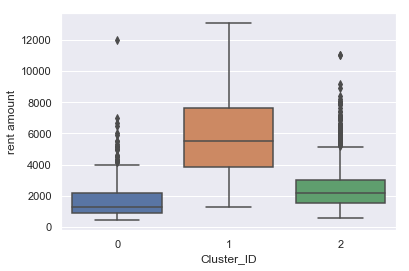

In [56]:
sns.boxplot(data_KMeans['Cluster_ID'],data_KMeans['rent amount'])

In [57]:
#Split data into clusters and run regression on them

data_KMeans['log_rent'] = log_rent
data_KMeans = data_KMeans.drop(['rent amount'],axis=1)

df_cluster1 = data_KMeans[data_KMeans['Cluster_ID']==0]
df_cluster2 = data_KMeans[data_KMeans['Cluster_ID']==1]
df_cluster3 = data_KMeans[data_KMeans['Cluster_ID']==2]

C:\Users\josep\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\josep\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  


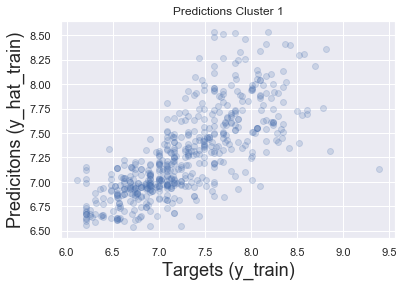

In [58]:
#Declare inputs and targets
targets1 = df_cluster1['log_rent']
inputs1 = df_cluster1.drop(['log_rent'],axis = 1)

#to standardise the inputs
scaler = StandardScaler()
scaler.fit(inputs1)
inputs_scaled1 = scaler.transform(inputs1)

#Split the data into train and test groups
x_train1,x_test1,y_train1,y_test1 = train_test_split(inputs_scaled1, targets1,test_size=0.2,random_state = 365)

#do the regression
reg1 = LinearRegression()
reg1.fit(x_train1,y_train1)

y_hat1 = reg1.predict(x_train1) #predicted results

plt.scatter(y_train1,y_hat1,alpha = 0.2)
plt.xlabel('Targets (y_train)',size=18)
plt.ylabel('Predicitons (y_hat_train)',size = 18)
plt.title('Predictions Cluster 1')

plt.show()

C:\Users\josep\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\josep\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  


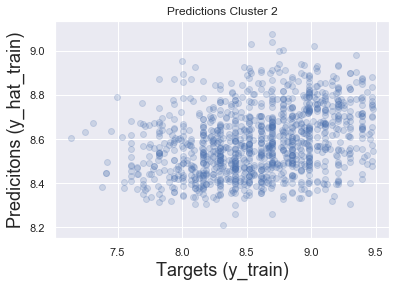

In [59]:
#Declare inputs and targets
targets2 = df_cluster2['log_rent']
inputs2 = df_cluster2.drop(['log_rent'],axis = 1)

#to standardise the inputs
scaler = StandardScaler()
scaler.fit(inputs2)
inputs_scaled2 = scaler.transform(inputs2)

#Split the data into train and test groups
x_train2,x_test2,y_train2,y_test2 = train_test_split(inputs_scaled2, targets2,test_size=0.2,random_state = 365)

#do the regression
reg2 = LinearRegression()
reg2.fit(x_train2,y_train2)

y_hat2 = reg2.predict(x_train2) #predicted results

plt.scatter(y_train2,y_hat2,alpha = 0.2)
plt.xlabel('Targets (y_train)',size=18)
plt.ylabel('Predicitons (y_hat_train)',size = 18)
plt.title('Predictions Cluster 2')

plt.show()

C:\Users\josep\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\josep\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  


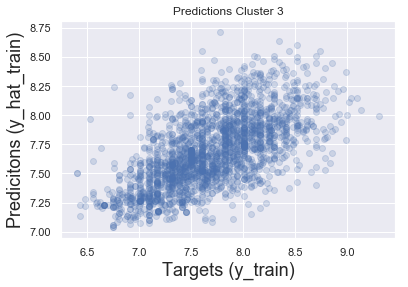

In [60]:
#Declare inputs and targets
targets3 = df_cluster3['log_rent']
inputs3 = df_cluster3.drop(['log_rent'],axis = 1)

#to standardise the inputs
scaler = StandardScaler()
scaler.fit(inputs3)
inputs_scaled3 = scaler.transform(inputs3)

#Split the data into train and test groups
x_train3,x_test3,y_train3,y_test3 = train_test_split(inputs_scaled3, targets3,test_size=0.2,random_state = 365)

#do the regression
reg3 = LinearRegression()
reg3.fit(x_train3,y_train3)

y_hat3 = reg3.predict(x_train3) #predicted results

plt.scatter(y_train3,y_hat3,alpha = 0.2)
plt.xlabel('Targets (y_train)',size=18)
plt.ylabel('Predicitons (y_hat_train)',size = 18)
plt.title('Predictions Cluster 3')

plt.show()

In [61]:
reg1.score(x_train1,y_train1)

0.5586462079115004

In [62]:
reg2.score(x_train2,y_train2)

0.10490393263154874

In [63]:
reg3.score(x_train3,y_train3)

0.3914053033321171

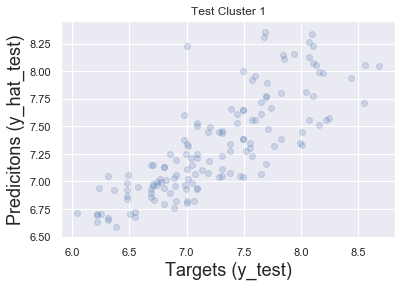

In [64]:
y_hat_test1 = reg1.predict(x_test1)
plt.scatter(y_test1,y_hat_test1,alpha = 0.2)
plt.xlabel('Targets (y_test)',size=18)
plt.ylabel('Predicitons (y_hat_test)',size = 18)
plt.title('Test Cluster 1')

plt.show()

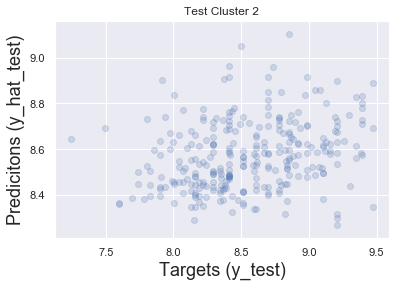

In [65]:
y_hat_test2 = reg2.predict(x_test2)
plt.scatter(y_test2,y_hat_test2,alpha = 0.2)
plt.xlabel('Targets (y_test)',size=18)
plt.ylabel('Predicitons (y_hat_test)',size = 18)
plt.title('Test Cluster 2')

plt.show()

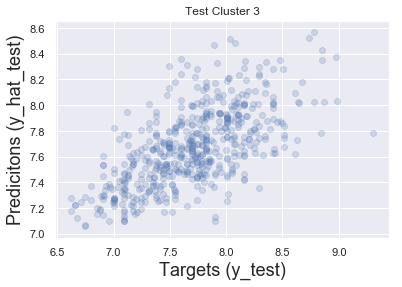

In [66]:
y_hat_test3 = reg3.predict(x_test3)
plt.scatter(y_test3,y_hat_test3,alpha = 0.2)
plt.xlabel('Targets (y_test)',size=18)
plt.ylabel('Predicitons (y_hat_test)',size = 18)
plt.title('Test Cluster 3')

plt.show()